# Pump it up challenge!

## Background

Using data from Taarifa and the Tanzanian Ministry of Water, try to predict which pumps are functional, which need some repairs, and which don't work at all.

An understanding of which pumps are failing can improve the accessibility of communities to clean water. Furthermore, if pumps are broken or faulty, less time will be spent reporting them and waiting for repairs. 

## Data

csv files containing a training set, test set and labels for both. Information about each pump is given related to:

- Installation data
- Location
- Height
- Population 
- Extraction type
- Management
- Payment
- Water quality
- Source
- Water point type

## Plan

- The model strategy:
    - Supervised
    - Classification
    - Batch learning
    - Performance measure should be precision/recall/F1.
    - Use RandomForest to determine which Features are not useful.
- Assumptions:
    - Use:
        - Given the same information as in the training set.
    - Subjective categories like "water_quality", "quantity" etc are correct.

## Goals
- Want a high recall for the broken pumps and the faulty but still functioning pumps. 
- Maybe have a recall of $>90\%$ with a precision of $>80\%$?
    - These can and will be reassesed. 




In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
# set style and figures plotted in jupyter notebook
plt.style.use('fivethirtyeight')
%matplotlib inline

### Preprocessing
# Use a transformer to do the onehotencoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
# import gridsearch package
# from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin

from preprocessing import get_ct_feature_names

# plotting
from plotting import plot_stations

# testing classifiers
from testing_classifiers import test_classifier, test_NN



Bad key "text.kerning_factor" on line 4 in
/Users/jamieward/.matplotlib/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "mathtext.fallback" on line 156 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "axes.titley" on line 177 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# read in data 

df_train = pd.read_csv("X_train_raw.csv")
df_labels = pd.read_csv("y_train_raw.csv")


# Data Exploration

In the following section, I print and visualise the dataset to gain inferences on how I should analyse the data. 

In [3]:
print(df_train.info())
print(df_labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

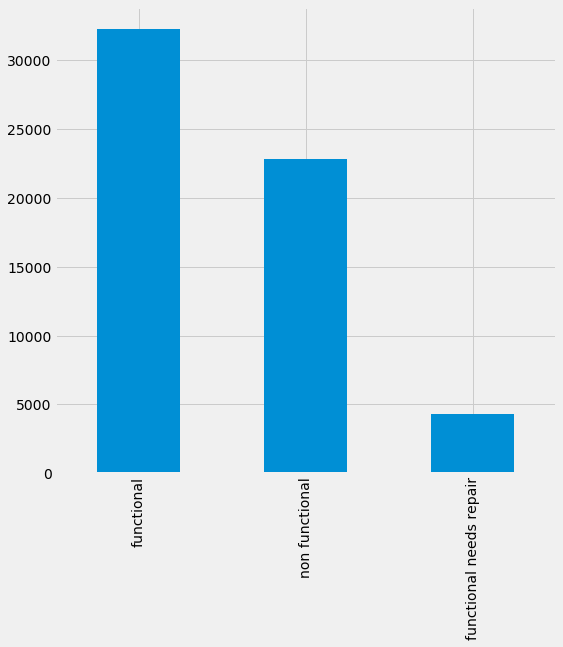

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


In [4]:
# plot the distribution of labels

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

df_labels["status_group"].value_counts().plot(kind='bar', ax=ax)
plt.show()
print(df_labels["status_group"].value_counts())


In [5]:
# pandas describe gives good summary info
df_train.describe()


,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


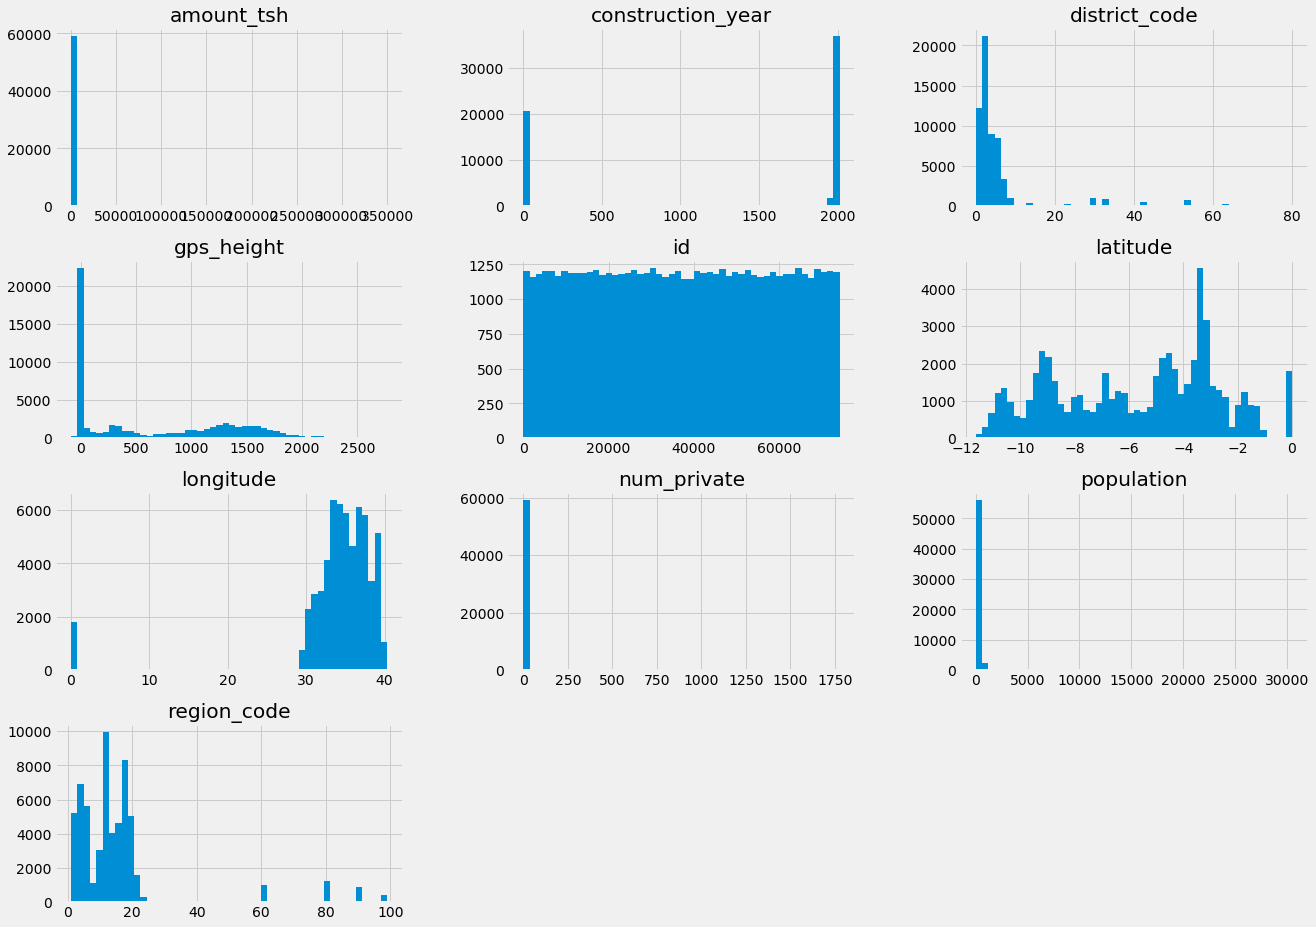

In [6]:
# plot distributions to infer more from the dataset

df_train.hist(bins=50, figsize=(20,15)) 
plt.show()

## Notes / thoughts 

- A lot of values are zero. 
    - Possibly due to any rows without information are just set to zero. 
    - Makes me wonder what is worth keeping. 
- Are these features important?
    - Might be irrelevant if you cant get this information...
- Most features are 'objects' or strings.
    - Need to convert to integers or floats or arrays via one hot encoding.
- Seems like a good dataset size with >50,000 non-null values but not sure how many are zero and want to get rid of...
    

/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please us

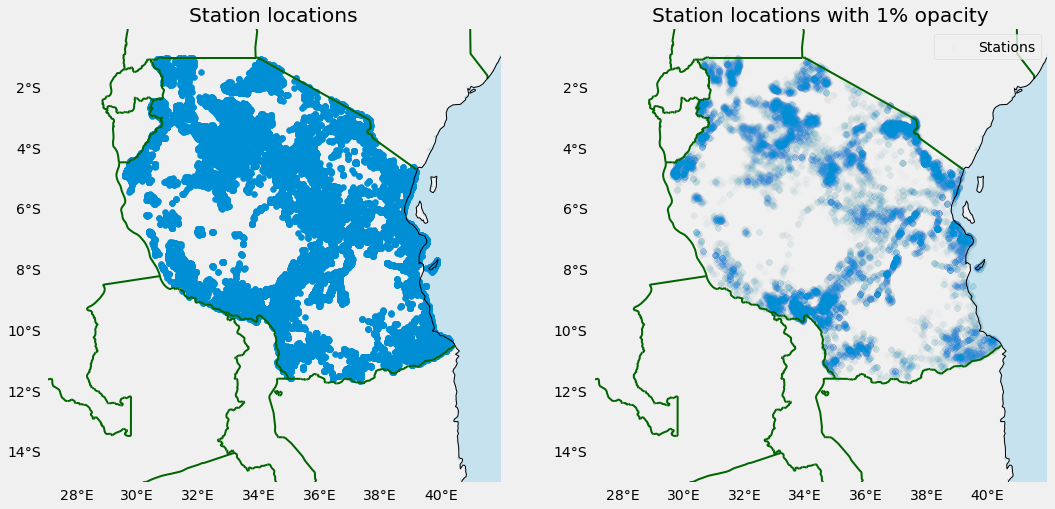

In [7]:
# plot locations of stations
df_train_labels = df_train.copy()

df_train_labels['labels'] = df_labels["status_group"].values

lons=np.array(df_train["longitude"])
lats=np.array(df_train["latitude"])

plot_stations(lons, lats)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')


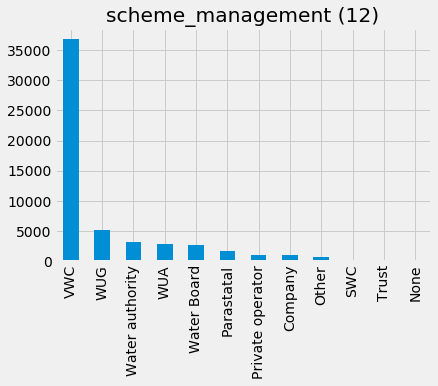

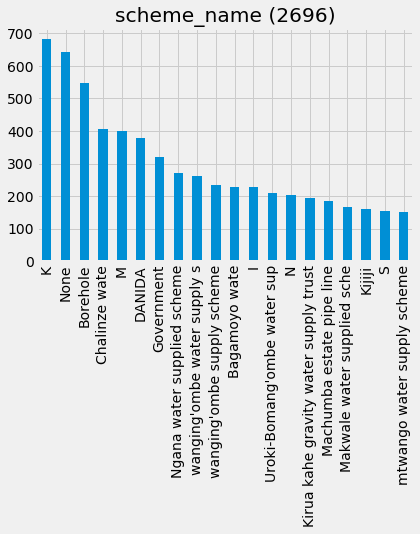

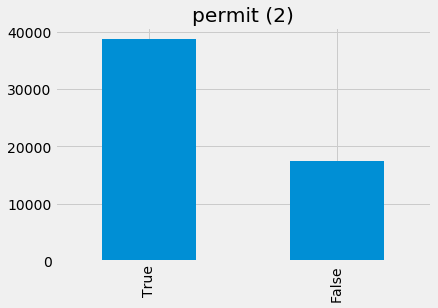

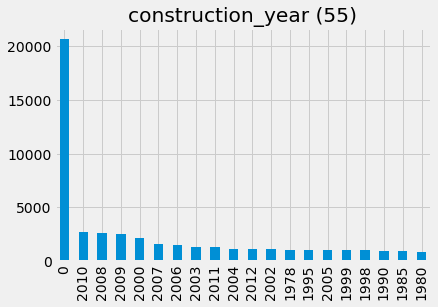

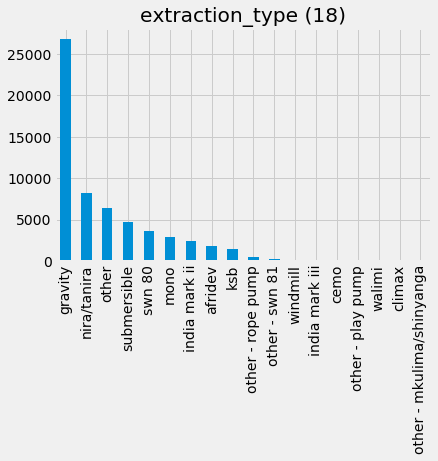

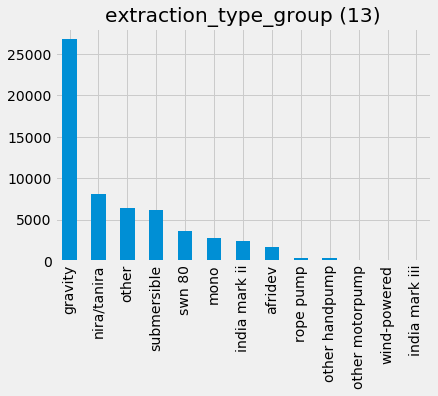

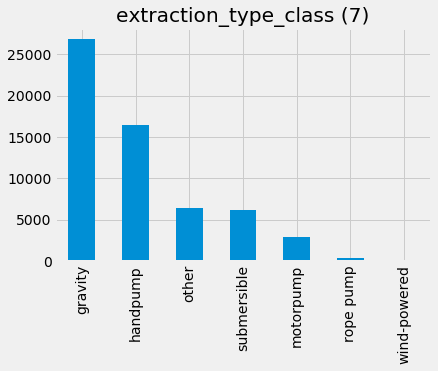

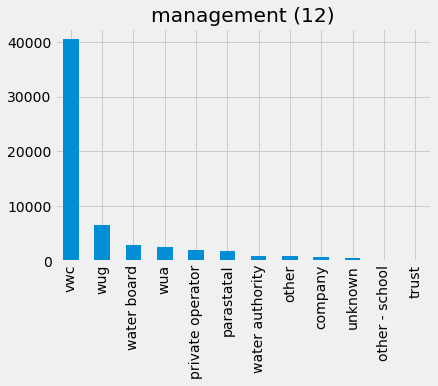

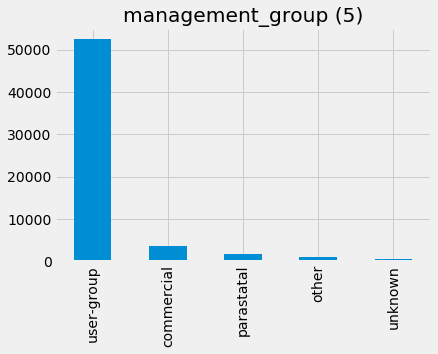

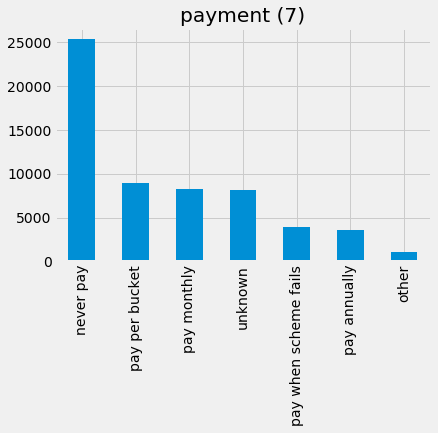

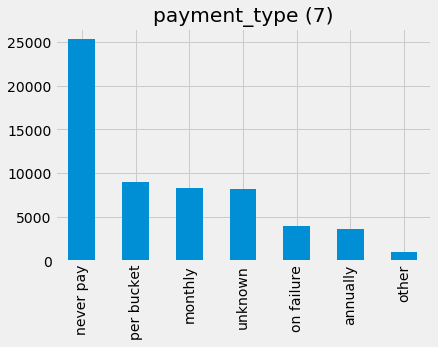

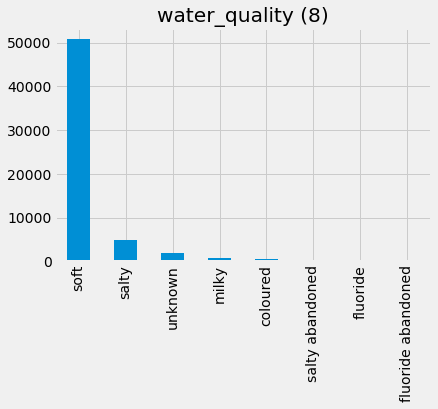

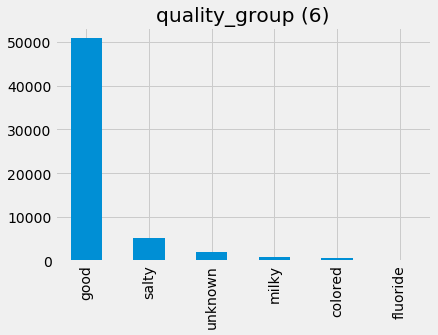

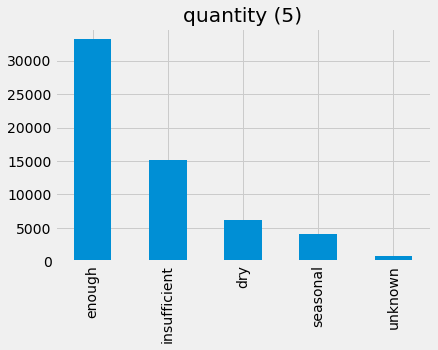

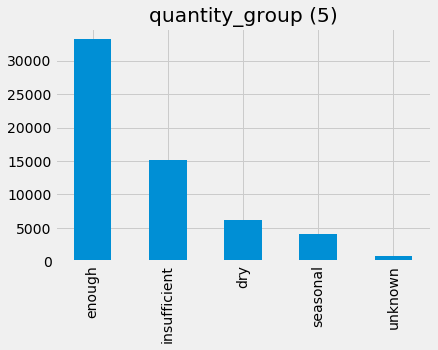

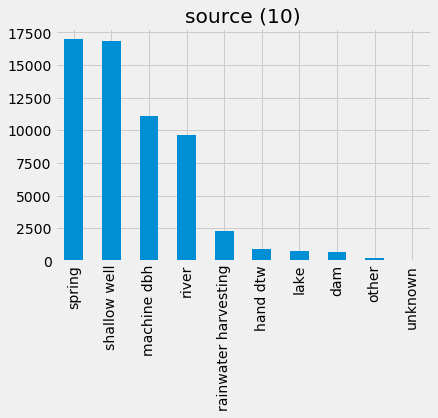

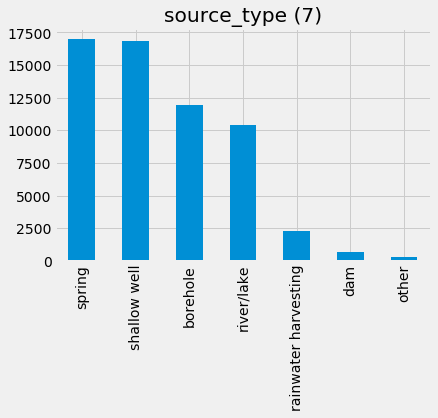

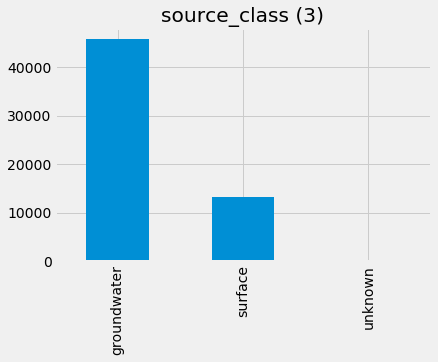

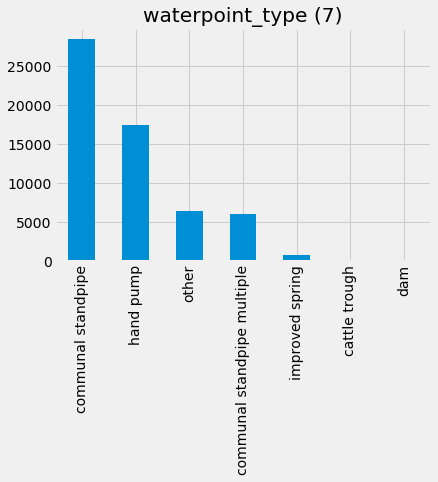

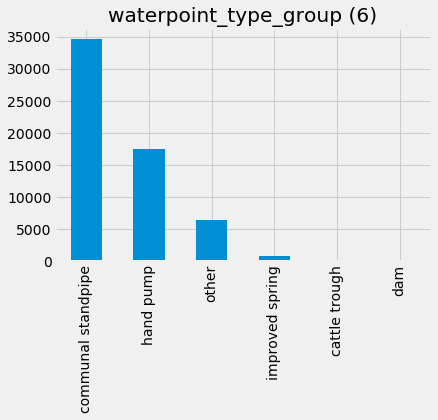

In [8]:
## counting values in some of the columns

print(df_train.keys())

for key in df_train.keys()[20:]:
    df_train[key].value_counts(sort=True).nlargest(20).plot.bar()
    plt.title(key + " (" + str(df_train[key].value_counts().shape[0]) + ")")
    plt.show()

    

## Preprocessing

### To do 

- Quantify the qualitative labels
- Decide what/if to scale some features
- Decide which to remove. 
    - They seem to have different columns with differing levels of detail e.g. "extraction_group", "extraction_group_type", "extraction_group_class"
    - Going to remove the ones with less detail?? 
- Decide which to combine. 

### What I have done to the dataset

- Replaces nans in scheme_management, permit with 'Unknown'
- Drop attribute called "scheme_name"
- Drop the first 20 attributes. 
- Change the construction year '0's to be the median?
    - 2000 is the median.
    - Better for feature scaling. 
    - As it turns out, construction year has a big influence on the prediction.
        - Going to remove the missing construction year ones. 

In [12]:

# attributes to be preprocessed using one hot encoding
cat_attribs = ['scheme_management', 'permit',
               'extraction_type', 'extraction_type_group', 'extraction_type_class',
               'management', 'management_group', 'payment', 'payment_type',
               'water_quality', 'quality_group', 'quantity', 'quantity_group',
               'source', 'source_type', 'source_class', 'waterpoint_type',
               'waterpoint_type_group']

# these were chosen by hand as those which i do not think would be useful
drop_attribs = ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
               'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
               'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
               'ward',  'public_meeting', 'recorded_by', 'scheme_name']

# numerical properties to be scaled
num_attribs = ['population','construction_year']

# Create pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values = 0, strategy = "median")),
    ('scaler', MinMaxScaler())
    
])
    
cat_pipeline = Pipeline([
    ('hot', OneHotEncoder(sparse=False)),
])
    
full_pipeline = ColumnTransformer([
    ("cat", cat_pipeline, cat_attribs),
    ("num", num_pipeline, num_attribs)
])

# convert to strings
for key in cat_attribs:
    df_train[key] = df_train[key].astype(str)
    
# convert to integers
for key in num_attribs:
    df_train[key] = df_train[key].astype(int)

# remove rows which have a construction year of zero
index_zero = df_train[ df_train['construction_year'] == 0 ].index
df_train.drop(index_zero , inplace=True)
df_labels.drop(index_zero , inplace=True)

df_prepared_fit = full_pipeline.fit(df_train)
df_prepared = full_pipeline.fit_transform(df_train)


In [13]:
feature_names = get_ct_feature_names(full_pipeline)
# pd.DataFrame(df_prepared, 
#              columns=feature_names

In [14]:
df_labels = df_labels['status_group']

df_labels

0            functional
1            functional
2            functional
3        non functional
5            functional
              ...      
59391    non functional
59394    non functional
59395        functional
59396        functional
59399        functional
Name: status_group, Length: 38691, dtype: object

## Training a linear SVM

- Going to start simple linear classification just to see if i have missed anything in the preprocessing.
- Probably to use some version of a random forest later to see which features aren't very useful.


/Users/jamieward/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7494507766664082
Precision: [0.72686124 0.80577878 0.        ]
Recall: [0.92485256 0.61719344 0.        ]


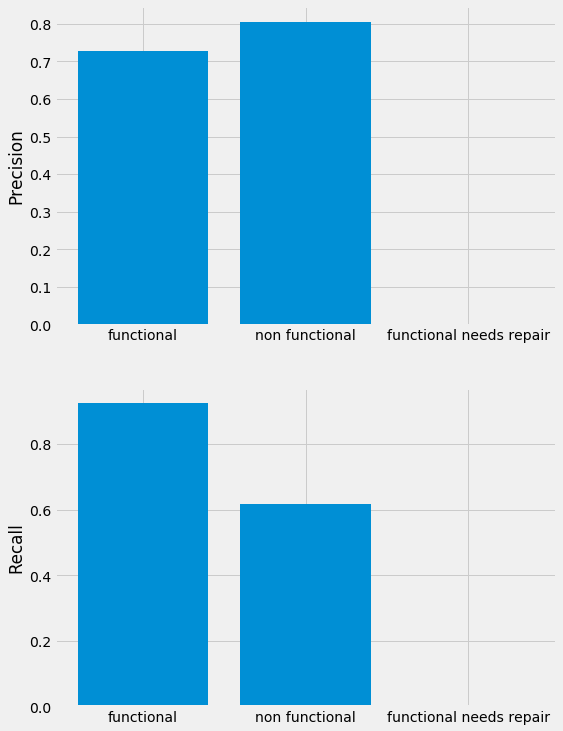

mean cross validation accuracy:  0.7487528977100827 +/- 0.007433726327568282


In [15]:
from sklearn.svm import LinearSVC

svc_clf = LinearSVC(C=10, loss="squared_hinge", max_iter=2000, dual=False, penalty='l2')

# svc_clf.fit(df_prepared, df_labels)

test_classifier(svc_clf, train=df_prepared, labels=df_labels)



## Thoughts on SVM attempts

- Linear SVM seems to perform better than polynomial or rgb kernels.
- Not too bad on the precison and recall maybe ill try and include it in an ensemble approach to the problem?
- Now going to try Decision trees.  

# Decision Tree Classifier

Accuracy: 0.7730221498539712
Precision: [0.74247504 0.86146572 0.62908012]
Recall: [0.93876705 0.6300574  0.16772152]


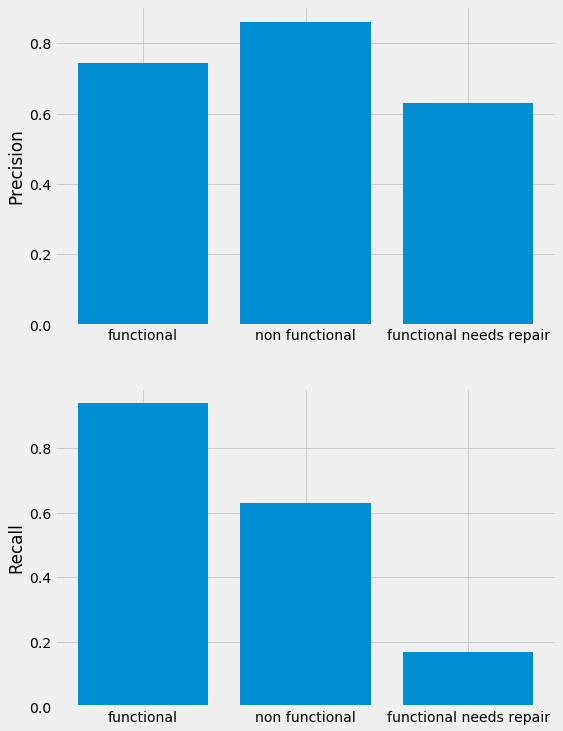

mean cross validation accuracy:  0.7575405245297712 +/- 0.005243732651189211


In [16]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=10, max_features=None) 


test_classifier(tree_clf, train=df_prepared, labels=df_labels)




Importances!

quantity_dry 29.461501791939444
waterpoint_type_other 18.088960223417892
construction_year 13.020502217469653
population 3.4271223200076397
waterpoint_type_communal standpipe 3.1689635313128304
quantity_group_enough 2.710993789798461
waterpoint_type_communal standpipe multiple 2.557776629297896
payment_type_never pay 2.36908718171446
management_company 1.9984407095093397
extraction_type_class_gravity 1.42275012777093
payment_never pay 1.1533445407346052
Accuracy: 0.7730221498539712
Precision: [0.7424386  0.86147882 0.63001486]
Recall: [0.93872097 0.63012656 0.16772152]


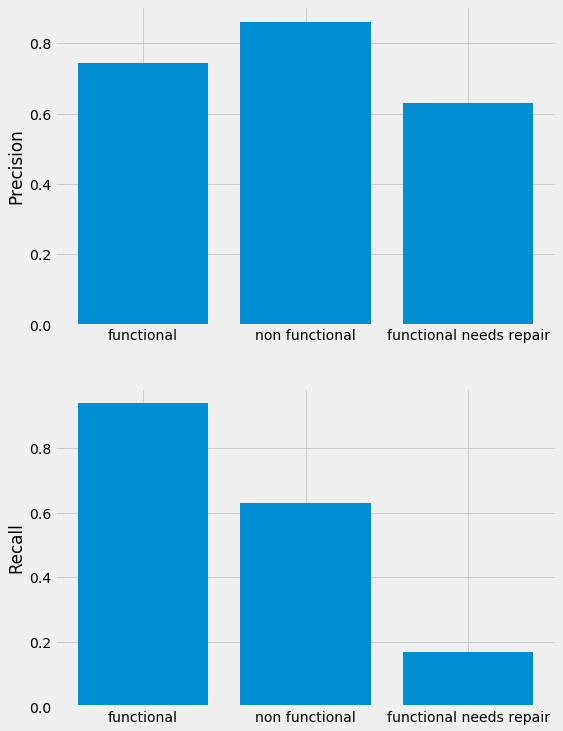

mean cross validation accuracy:  0.7574888249071831 +/- 0.00518337014539066


In [17]:

importances = np.array(tree_clf.feature_importances_)*100
names = feature_names

# combine feature names and their importances
sorted_importances, sorted_names = (list(t) for t in zip(*sorted(zip(tree_clf.feature_importances_, feature_names), reverse=True)))

print("\nImportances!\n")
count=0
for importance, name in zip(sorted_importances, sorted_names):
    print(name, importance*100)
    count +=1
    if count > 10:
        break

test_classifier(tree_clf, train=df_prepared, labels=df_labels)


# Logistic Regression

Accuracy: 0.7504846088237574
Precision: [0.73496213 0.79202353 0.44      ]
Recall: [0.91199779 0.63316965 0.03481013]


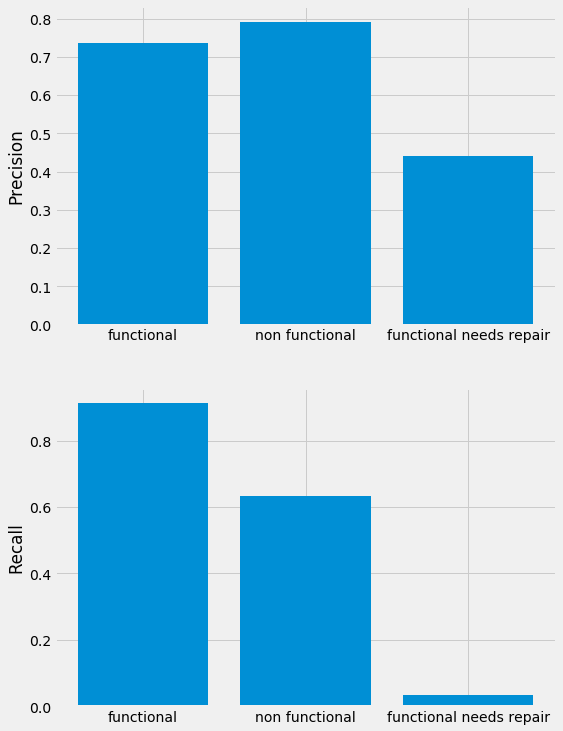

mean cross validation accuracy:  0.7483911205681149 +/- 0.007320891785136169


In [18]:
from sklearn.linear_model import LogisticRegression 

log_reg = LogisticRegression(C=20,max_iter=1000)

test_classifier(log_reg, train=df_prepared, labels=df_labels)


# Random Forest

Accuracy: 0.7849887570752888
Precision: [0.75050038 0.87810829 0.7045045 ]
Recall: [0.95019351 0.64720935 0.15466772]


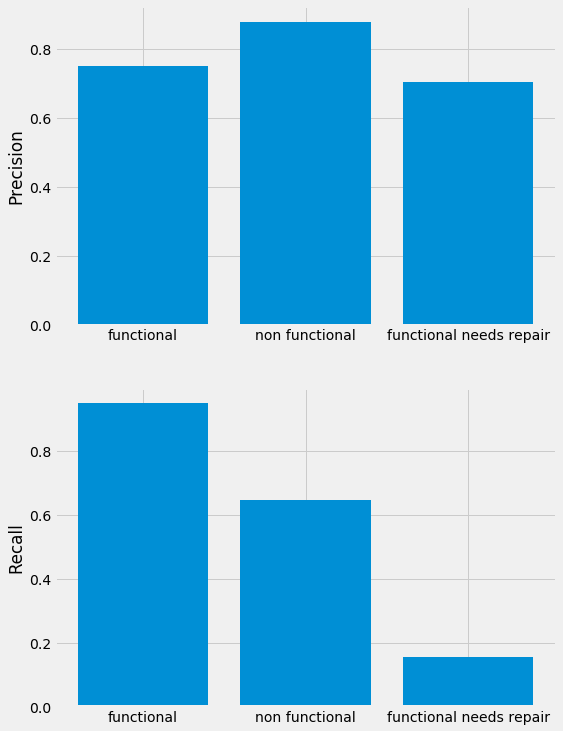

mean cross validation accuracy:  0.7685765673347345 +/- 0.007574140985836785

Importances!

0 quantity_dry 17.12350890899436
1 construction_year 12.671820978335841
2 quantity_group_dry 11.457081570350613
3 waterpoint_type_group_other 10.571764465860037
4 waterpoint_type_other 7.012179214609265
5 population 4.2428921787767075
6 waterpoint_type_communal standpipe 3.0010225517981666
7 waterpoint_type_communal standpipe multiple 2.7095038384122105
8 payment_never pay 2.1161089199648133
9 payment_type_never pay 1.7450093128159327


In [19]:
## Ok try the random forests now 

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, max_depth=10, max_features=None)

test_classifier(forest_clf, train=df_prepared, labels=df_labels)

# combine feature names and their importances
sorted_importances, sorted_names = (list(t) for t in zip(*sorted(zip(forest_clf.feature_importances_, feature_names), reverse=True)))

print("\nImportances!\n")
count=0
for importance, name in zip(sorted_importances, sorted_names):
    print(count, name, importance*100)
    count +=1
    if count == 10:
        break

# hyperparameter tuning, not worthwhile for this work

# param_grid = [
# {'n_estimators': [50,100,250,500,1000]},
# ]



# grid_search = GridSearchCV(forest_clf, param_grid, cv=5, 
#                            scoring='accuracy',
#                            return_train_score=True)


# grid_search.fit(df_prepared, df_labels)

# print(grid_search.best_params_)

# test_classifier(grid_search.best_estimator_, train=df_prepared, labels=df_labels)


# Adaptive Boosting 

Accuracy: 0.8378175803158358
Precision: [0.81666065 0.88324954 0.80387409]
Recall: [0.93770734 0.76547479 0.39398734]


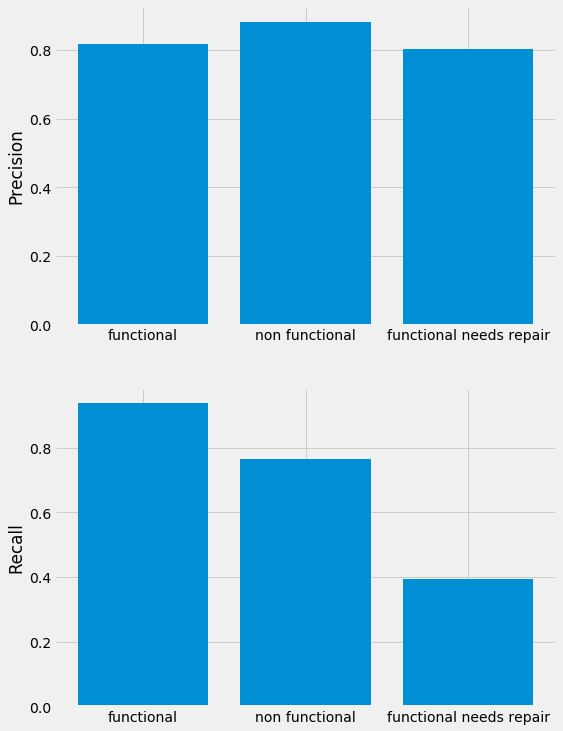

mean cross validation accuracy:  0.7688865379953156 +/- 0.007674367560771442


In [20]:
# Now for adaptive boosting classifiers with decision trees

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(tree_clf, n_estimators=10, 
                             algorithm="SAMME.R", learning_rate=0.5)

test_classifier(ada_clf, train=df_prepared, labels=df_labels)


# Neural network preparation and training

In [21]:
# data preparation for NN

df_prep_nn = df_prepared.astype(float)
enc = OneHotEncoder(sparse=False)

df_labels = enc.fit_transform(np.array(df_labels).reshape(-1,1))

print(df_labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [22]:
## ok again!
# Lets try a simple NN using tensorflow!

import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[144]))
model.add(keras.layers.Dense(200, activation="relu")) 
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(3, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy"])

2022-04-27 09:48:22.779668: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-27 09:48:22.808811: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcdbcb06420 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-27 09:48:22.808827: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [23]:
# history = model.fit(df_prepared, df_labels, validation_split=0.3, epochs=50)
# print(df_prepared.shape)

test_NN(model, train=df_prep_nn, labels=df_labels, epochs=1, val_split=0.2)


Train on 30952 samples, validate on 7739 samples
30952/30952 [==============================] - 4s 120us/sample - loss: 0.6277 - accuracy: 0.7464 - val_loss: 0.5908 - val_accuracy: 0.7657
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
Accuracy: 0.7651650254581168
Precision: [0.74095014 0.5497076  0.83115831]
Recall: [0.92987468 0.07436709 0.63870254]
